# Faster R-CNN

In [ ]:
# installation script for the required packages
# torch >= 1.12.0
# torchvision >= 0.13.0
# torchmetrics >= 0.7.0
# pycocotools >= 2.0.6
# albumentations >= 1.3.0
# matplotlib >= 3.5.1
!pip install torch torchvision torchmetrics pycocotools albumentations matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 36.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from google.colab import drive # mount google drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import os # set the path to your dataset
import numpy as np # for numerical operations
import torch # for deep learning
import torchvision # for computer vision tasks 
from torch.utils.data import Dataset, DataLoader # for custom dataset and data loader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # for object detection model predictor layer 
from pycocotools.coco import COCO # for COCO dataset handling 
from PIL import Image # for image processing
import albumentations as A # for data augmentation
from albumentations.pytorch import ToTensorV2 # for converting images to PyTorch tensors
from torchmetrics.detection.mean_ap import MeanAveragePrecision # for mean average precision metric
import matplotlib.pyplot as plt # for plotting
import cv2 # for image processing

In [ ]:
class CocoDataset(Dataset):
    """
    Custom dataset class for loading COCO dataset images and annotations.
    Args:   
        root_dir (str): The root directory of the COCO dataset.
        annotation_file (str): The path to the COCO annotations file.
        transforms (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.ids) # total number of images

    def __getitem__(self, idx):
        img_id = self.ids[idx] # get image id
        # Load annotations for the image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids) # load annotations

        img_info = self.coco.loadImgs(img_id)[0] # load image info
        img_path = os.path.join(self.root_dir, img_info['file_name']) # get image path
        image = Image.open(img_path).convert("RGB") # open image and convert to RGB
        image = np.array(image) # convert image to numpy array

        boxes = [] # list to store bounding boxes
        labels = [] # list to store labels
        # Iterate through annotations and extract bounding boxes and labels
        for ann in annotations:
            # Check if segmentation is available and has points to process
 
            if 'segmentation' in ann and len(ann['segmentation']) > 0:
                all_points = [] # list to store all points
                # Iterate through segmentation points
                for seg in ann['segmentation']:
                    points = np.array(seg).reshape(-1, 2) # convert segmentation points to numpy array
                    all_points.extend(points) # extend the list with points

                if len(all_points) > 0:
                    # Convert points to numpy array and calculate bounding box
                    all_points = np.array(all_points)
                    # Calculate min and max coordinates
                    # to create a bounding box
                    x_min, y_min = np.min(all_points, axis=0)
                    x_max, y_max = np.max(all_points, axis=0)

                    x_min = max(0, x_min)
                    y_min = max(0, y_min)
                    x_max = min(img_info['width'], x_max)
                    y_max = min(img_info['height'], y_max)
                    # Check if the bounding box is valid
                    # and add it to the list
                    if x_max > x_min and y_max > y_min:
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(ann['category_id'])

        # Convert to numpy arrays first to avoid memory issues
        boxes = np.array(boxes, dtype=np.float32) if len(boxes) > 0 else np.zeros((0, 4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if len(labels) > 0 else np.zeros((0,), dtype=np.int64)

        # Apply transforms if available before returning
        # to avoid memory issues
        # Check if transforms are available and apply them
        if self.transforms is not None:
            #  Apply transforms to the image and annotations
            # Use try-except to handle any errors during transformation
            try:
                transformed = self.transforms(
                    image=image,
                    bboxes=boxes,
                    class_labels=labels
                )
                image = transformed['image'] # transformed image
                # transformed bounding boxes and labels
                boxes = np.array(transformed['bboxes'], dtype=np.float32) if len(transformed['bboxes']) > 0 else np.zeros((0, 4), dtype=np.float32)
                # Convert class labels to numpy array
                # and handle empty case
                labels = np.array(transformed['class_labels'], dtype=np.int64) if len(transformed['class_labels']) > 0 else np.zeros((0,), dtype=np.int64)
            except Exception as e:
                print(f"Transform error: {e}")
                boxes = np.zeros((0, 4), dtype=np.float32) # empty boxes array 
                labels = np.zeros((0,), dtype=np.int64)     # empty labels array  

        # Convert to tensors after transforms
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([img_id]),
            'area': torch.as_tensor((boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]), dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0,), dtype=torch.float32),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        return image, target

In [ ]:
def get_transform(train):
    """
    Get the transformation pipeline for training and validation.
    Args:
        train (bool): True for training, False for validation.
    Returns:
        albumentations.Compose: The transformation pipeline.
    """
    # Define the transformation pipeline for training and validation.
    # The pipeline includes horizontal flip, random brightness and contrast, resizing, normalization, and conversion to tensor.
    # The pipeline also includes bounding box annotation for training.
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Resize(height=800, width=800),
            A.Normalize(),  # Add normalization to [0, 1]
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['class_labels'],
            min_area=1,
            min_visibility=0.1
        ))
    else:
        return A.Compose([
            A.Resize(height=800, width=800),
            A.Normalize(),  # Add normalization to [0, 1]
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['class_labels'],
            min_area=1,
            min_visibility=0.1
        ))

def collate_fn(batch):
    return tuple(zip(*batch))

# define get model function
# to load the pre-trained Faster R-CNN model
# and the corresponding predictor
def get_model(num_classes):
    """
    Load a pre-trained Faster R-CNN model and replace the classifier with a new one.
    Args:
        num_classes (int): The number of classes in the dataset.
    Returns:
        torchvision.models.detection.FasterRCNN: The modified Faster R-CNN model.
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# torch no_grad decorator is used to disable gradient computation during evaluation.
@torch.no_grad()
# define evaluate function
# to evaluate the model on the validation set
# and return the mean average precision (mAP)
def evaluate(model, data_loader, device):
    """
    Evaluate the model on the validation set and compute mAP.
    Args:
        model (torchvision.models.detection.FasterRCNN): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): The data loader for the validation set.
        device (torch.device): The device to run the model on.
    Returns:
        float: The mean average precision (mAP) on the validation set.
    """
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")

    # Iterate through the validation data loader
    # and compute the predictions and targets
    # for each batch of images
    # and accumulate the metrics
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        preds = model(images)
        metric.update(preds, targets)

    metrics = metric.compute()
    print(f"\nValidation Metrics:")
    print(f"mAP@0.5: {metrics['map_50'].item():.4f}")
    print(f"mAP@0.5:0.95: {metrics['map'].item():.4f}\n")

    return 1 - metrics["map"].item()

# define train function
# to train the model for one epoch
# and return the average loss for the epoch
# torch no_grad decorator is used to disable gradient computation during evaluation.
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """
    Train the model for one epoch and compute the average loss.
    Args:
        model (torchvision.models.detection.FasterRCNN): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        data_loader (torch.utils.data.DataLoader): The data loader for the training set.
        device (torch.device): The device to run the model on.
        epoch (int): The current epoch number.
    Returns:
        float: The average loss for the epoch.
    """
    model.train()
    metric = MeanAveragePrecision()
    total_loss = 0

    # Iterate through the training data loader
    # and compute the loss for each batch of images
    # and accumulate the losses
    # and update the model parameters
    # and update the optimizerparameters
    # and update the metrics
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            preds = model(images)
            metric.update(preds, targets)
            model.train()

        if i % 50 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {losses.item()}")

    metrics = metric.compute()
    print(f"Epoch {epoch} Metrics: mAP@0.5={metrics['map_50']}, mAP={metrics['map']}")
    metric.reset()
    return total_loss / len(data_loader)

In [ ]:

train_losses = [] # list to store training losses
val_losses = [] # list to store validation losses

# define main function
# to load the dataset, create data loaders,
# create the model, train the model, and evaluate the model
def main():
    """
    Main function to load the dataset, create data loaders,
    create the model, train the model, and evaluate the model.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using device: {device}")

    # Dataset paths
    train_dir = "/content/drive/MyDrive/Faster-RCNN_265/coco json format/train/images"
    train_ann = "/content/drive/MyDrive/Faster-RCNN_265/coco json format/train/train_annotations.json"
    val_dir = "/content/drive/MyDrive/Faster-RCNN_265/coco json format/val/images"
    val_ann = "/content/drive/MyDrive/Faster-RCNN_265/coco json format/val/val_annotations.json"

    # Load dataset
    coco = COCO(train_ann)
    num_classes = len(coco.cats) + 1  # +1 for background

    # Create datasets
    train_dataset = CocoDataset(train_dir, train_ann, get_transform(train=True))
    val_dataset = CocoDataset(val_dir, val_ann, get_transform(train=False))

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=2, shuffle=True,
        collate_fn=collate_fn, num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=2, shuffle=False,
        collate_fn=collate_fn, num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Initialize model
    model = get_model(num_classes)
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Training loop
    num_epochs = 10

    '''for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        val_loss = evaluate(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)'''
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        val_loss = evaluate(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)


    # Save model with class info
    class_info = {
        'num_classes': num_classes,
        'categories': coco.loadCats(coco.getCatIds())
    }
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_info': class_info
    }, "fasterrcnn_model.pth")
    print("Training complete. Model saved.")

if __name__ == "__main__":
    main()

Using device: cuda
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 3.5492422580718994
Epoch: 0, Batch: 50, Loss: 1.093902587890625
Epoch: 0, Batch: 100, Loss: 0.676744282245636
Epoch: 0, Batch: 150, Loss: 0.5651439428329468
Epoch: 0, Batch: 200, Loss: 0.9469463229179382
Epoch: 0, Batch: 250, Loss: 0.39187219738960266
Epoch: 0, Batch: 300, Loss: 0.5449333190917969
Epoch: 0, Batch: 350, Loss: 0.5795168280601501
Epoch: 0, Batch: 400, Loss: 0.41858363151550293
Epoch: 0, Batch: 450, Loss: 0.6247257590293884
Epoch: 0, Batch: 500, Loss: 0.8283455967903137
Epoch: 0, Batch: 550, Loss: 0.5010300874710083
Epoch: 0, Batch: 600, Loss: 1.0140198469161987
Epoch: 0, Batch: 650, Loss: 0.5016797780990601
Epoch: 0, Batch: 700, Loss: 0.643553614616394
Epoch: 0, Batch: 750, Loss: 0.32264500856399536
Epoch: 0, Batch: 800, Loss: 0.6404116749763489
Epoch: 0, Batch: 850, Loss: 0.6374329924583435
Epoch: 0, Batch: 900, Loss: 0.5660237073898315
Epoch: 0, Batch: 950, Loss: 0.3496144115924835
Epoch: 0, Batch: 1000, Loss: 1.0776983499526978
Epoch: 0, Batch

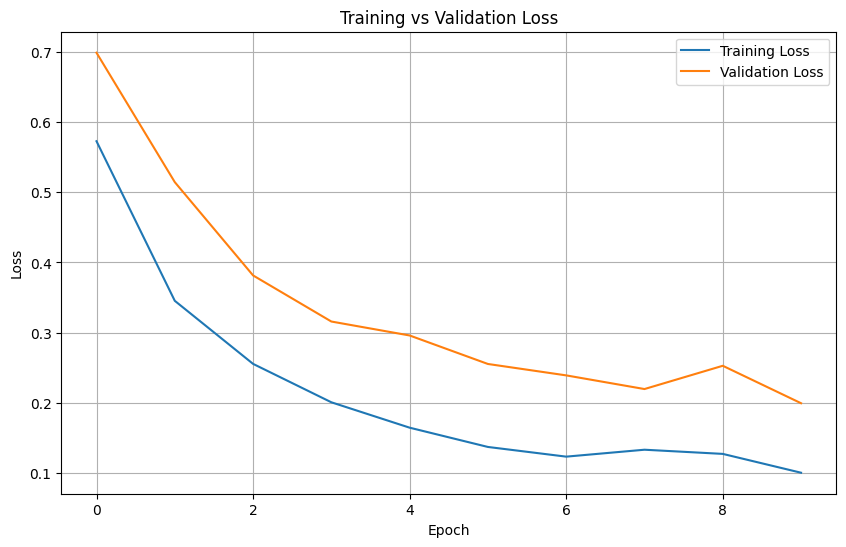

In [ ]:
# Plot loss curves for training and validation
plt.figure(figsize=(10, 6)) # set figure size
plt.plot(train_losses, label='Training Loss') # plot training loss
plt.plot(val_losses, label='Validation Loss') # plot validation loss
plt.xlabel('Epoch') # set x-axis label
plt.ylabel('Loss') # set y-axis label
plt.title('Training vs Validation Loss') # set title
plt.legend() # add legend
plt.grid(True) # add grid
plt.show() # show plot


In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint = torch.load("fasterrcnn_model.pth", map_location=device)
num_classes = checkpoint['class_info']['num_classes']

# Restore the model before test
model = get_model(num_classes) # create model with correct number of classes
model.load_state_dict(checkpoint['model_state_dict']) # load model state dict
model.to(device) # move model to device
model.eval() # set model to evaluation mode

# Reinitialize and load model on correct device
model = get_model(num_classes) # create model with correct number of classes
checkpoint = torch.load("fasterrcnn_model.pth", map_location=device) # load checkpoint on correct device
model.load_state_dict(checkpoint['model_state_dict']) # load model state dict
model.to(device) # move model to device
model.eval() # set model to evaluation mode

# Test evaluation
test_dir = "/content/drive/MyDrive/Faster-RCNN_265/coco json format/test/images"
test_ann = "/content/drive/MyDrive/Faster-RCNN_265/coco json format/test/test_annotations.json"
test_dataset = CocoDataset(test_dir, test_ann, get_transform(train=False))
test_loader = DataLoader(
    test_dataset, batch_size=2, shuffle=False, # set batch size to 2 and shuffle to false
    collate_fn=collate_fn, num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print("Evaluating on test set...")
evaluate(model, test_loader, device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=1.33s)
creating index...
index created!
Evaluating on test set...

Validation Metrics:
mAP@0.5: 0.9899
mAP@0.5:0.95: 0.8321



0.1679210066795349

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


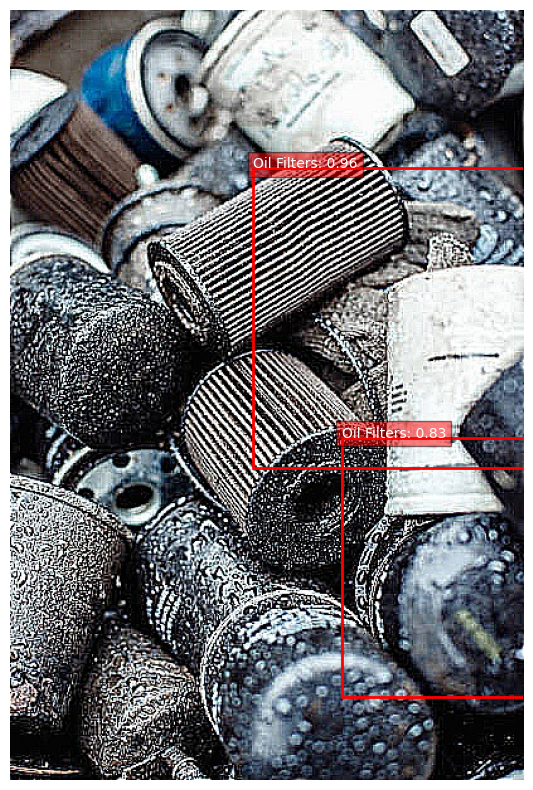

In [ ]:
import torch # for deep learning
import torchvision.transforms as T # for image transformations
from PIL import Image # for working with images
import matplotlib.pyplot as plt # for plotting
import matplotlib.patches as patches # for drawing bounding boxes

# Load model and class info
checkpoint = torch.load("/content/fasterrcnn_model.pth", map_location=torch.device('cpu'))  # use device='cuda' if using GPU
num_classes = checkpoint['class_info']['num_classes']  # get number of classes
categories = checkpoint['class_info']['categories'] # get categories

# Rebuild model
from torchvision.models.detection import fasterrcnn_resnet50_fpn # import Faster R-CNN model from torchvision models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # import FastRCNNPredictor from torchvision models detector module

model = fasterrcnn_resnet50_fpn(pretrained=False) # load Faster R-CNN model without pre-trained weights
in_features = model.roi_heads.box_predictor.cls_score.in_features # get input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the classifier with a new one
model.load_state_dict(checkpoint['model_state_dict']) # load model state dict
model.eval() # set model to evaluation mode
# Load and preprocess image
image_path = "/content/drive/MyDrive/Faster-RCNN_265/coco json format/test/images/of1_aug_1.jpg"
image = Image.open(image_path).convert("RGB") # open image and convert to RGB
transform = T.Compose([
    T.Resize((800, 800)), # resize image to 800x800
    T.ToTensor() # convert image to tensor
])
img_tensor = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    prediction = model(img_tensor)[0]

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        class_name = next((c['name'] for c in categories if c['id'] == label.item()), f"ID {label.item()}")
        ax.text(x1, y1, f"{class_name}: {score:.2f}", color='white',
                bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()
